<a href="https://colab.research.google.com/github/tonyscan6003/CE6003/blob/master/Example_3_3__BoF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification with Bag of Features 
In this example we will perform image recognition using the bag of features representation. For this example we will use [Intel Scene Classification Dataset](https://www.kaggle.com/puneet6060/intel-image-classification), which has 6 classes as shown. 

In addition to loading and preparing the dataset, this example notebook demonstrates the key steps in training and testing a Bag of Features based classifier:


*   Building (& Visualising) the Vocabulary
*   Converting the Data to the BoF (Histogram Representation)
*   Training & testing the classifier.




![dataset](https://cdn-images-1.medium.com/max/800/1*Y1y83HN7oI98EJT3LQgv-g.png)








**HouseKeeping**: Downgrade OpenCV version to allow access to SIFT detector/descriptor, Import Python Packages.

In [ ]:
! yes | pip3 uninstall opencv-python

! yes | pip3 uninstall opencv-contrib-python

! yes | pip3 install opencv-python==3.4.2.16
 
! yes | pip3 install opencv-contrib-python==3.4.2.16

In [5]:
import numpy as np
from skimage.data import lfw_subset
from skimage import feature
from skimage import exposure
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from sklearn import preprocessing
import cv2
import glob
import random
import matplotlib.pyplot as plt

# import tensorflow_datasets as tfds
from tqdm import tqdm

%load_ext lab_black

# A. (Part 1) Load Dataset.
The Intel Scenes dataset is loaded from [Kaggle](https://www.kaggle.com/puneet6060/intel-image-classification), this allows fast importation of the dataset. Ensure that you have a valid [kaggle.json](https://github.com/tonyscan6003/CE6003/blob/master/images/CE6003_kaggle_data_instructions.pdf) file ready to upload.



In [ ]:
! pip install -q kaggle==1.5.6
from google.colab import files
files.upload()

In [ ]:
#Choose the kaggle.json file that you downloaded
! mkdir ~/.kaggle
#Make directory named kaggle and copy kaggle.json file there.
! cp kaggle.json ~/.kaggle/
#Change the permissions of the file.
! chmod 600 ~/.kaggle/kaggle.json

# Load dataset
! kaggle datasets download puneet6060/intel-image-classification

In [ ]:
!unzip intel-image-classification.zip > /dev/null
!ls

# A (part 2). Prepare Dataset:
In order to prepare the Intel scenes dataset for use with the BoF approach we need to follow a number of steps:


1.   Obtain a list of downloaded files in the test and training folders, we use the glob package to do this.
2.   Secondly the files must be imported and added to arrays of images.


> *   The images files are selected at random to breakup the directory structure which groups the files by class. 
* The images are converted to greyscale.
* The images are scaled so that they are all the same size.

3. The labels for each image are obtained from the file string (in step 1). In order to use the SKlearn classifiers (Part D), the labels must be numerical. The sklearn preprocessing methods can be used to convert the label to a numerical value.    









1. Create File List for Training & Test data

In [29]:
"../kaggle/seg_train/seg_train/*/*.jpg".split("/")

['..', 'kaggle', 'seg_train', 'seg_train', '*', '*.jpg']

In [45]:
def gen_list():
    # use glob command to find the appropiate natural image files.
    train_img_list = glob.glob("../kaggle/seg_train/seg_train/*/*.jpg")
    # Obtain Class labels from directory name
    train_label_list = [
        train_img_list[i].split("/")[-1].split("\\")[1]
        for i in range(0, len(train_img_list))
    ]

    test_img_list = glob.glob("../kaggle/seg_test/seg_test/*/*.jpg")
    test_label_list = [
        test_img_list[i].split("/")[-1].split("\\")[1]
        for i in range(0, len(test_img_list))
    ]
    return train_img_list, train_label_list, test_img_list, test_label_list

In [46]:
train_img_list, train_label_list, test_img_list, test_label_list = gen_list()

In [48]:
max_train_examples = len(train_img_list)
max_test_examples = len(test_img_list)
print("The maximum number available of Training images are ", max_train_examples)
print("The maximum number available of Test images are ", max_test_examples)

The maximum number available of Training images are  14034
The maximum number available of Test images are  3000


2. Import (greyscale) image files into array

In [49]:
# Target Image size
HW_trg = 150

# Generator function to yield random order image file each time generator is called
def _sel_img_rnd():
    shuff_all_list = np.arange(max_train_examples)
    np.random.shuffle(shuff_all_list)
    fid_list = shuff_all_list[0:num_train_examples]
    i = 0
    while 1:
        fid = fid_list[i]
        img_str = train_img_list[fid]
        label_str = train_label_list[fid]
        i += 1
        yield img_str, label_str


# Resize short axis to n and crop the image to n x n
def _resize_crop(image):
    img_H = np.shape(image)[0]
    img_W = np.shape(image)[1]
    if (img_H == HW_trg) and (img_W == HW_trg):
        crop_image = image
    else:
        flag_1 = img_H > img_W
        min_dim_size = min(img_H, img_W)
        scale_fac = HW_trg / min_dim_size
        scale_img_H = int(np.ceil(np.shape(image)[0] * scale_fac))
        scale_img_W = int(np.ceil(np.shape(image)[1] * scale_fac))
        rescale_image = cv2.resize(
            image, (scale_img_W, scale_img_H), interpolation=cv2.INTER_AREA
        )
        rescale_H = np.shape(rescale_image)[0]
        rescale_W = np.shape(rescale_image)[1]
        if flag_1 == True:  # Height greater than width
            c_y = int(rescale_H // 2)
            c_y_min = int(c_y - HW_trg // 2)
            c_y_max = int(c_y + HW_trg // 2)
            crop_image = rescale_image[c_y_min:c_y_max, 0:HW_trg]
        else:  # Width greater than height
            c_x = rescale_W // 2
            c_x_min = int(c_x - HW_trg // 2)
            c_x_max = int(c_x + HW_trg // 2)
            crop_image = rescale_image[0:HW_trg, c_x_min:c_x_max]
    return crop_image


# Function to read image from string
def _read_image(image_str, label_str):
    real_image = cv2.imread(image_str, cv2.IMREAD_GRAYSCALE)
    return real_image, label_str


# Main function to create array of images
def gen_img_stack(n_examples, rnd=True):
    X_data = np.empty([HW_trg, HW_trg])
    y_train = []
    gen = _sel_img_rnd()
    for i in tqdm(range(n_examples)):
        # File name and label from generator
        image_str, label_str = next(gen)
        image, label_str = _read_image(image_str, label_str)
        image = _resize_crop(image)
        # image =  cv2.GaussianBlur(image,(k_size,k_size),sigma)
        # Append to dataset
        X_train = np.dstack((X_train, image)) if i > 0 else image
        y_train = np.append(y_train, label_str)
    return X_train, y_train

In [50]:
# Generate Datasets
num_train_examples = 1500
num_test_examples = 500
X_train, y_train = gen_img_stack(num_train_examples, rnd=True)
X_test, y_test = gen_img_stack(num_test_examples, rnd=False)

100%|██████████| 500/500 [00:01<00:00, 425.53it/s]


3. Process the labels.

In [51]:
# Convert the labels to numbers for sklearn.
le = preprocessing.LabelEncoder()

y_train_bof = le.fit_transform(y_train)
y_test_bof = le.transform(y_test)

list(le.classes_)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

4. Plot some examples from the Training dataset.

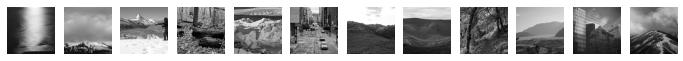

In [55]:
i = 0
n_plots = 12  # number of plots
f, axarr = plt.subplots(1, n_plots, figsize=(12, 10))

for i in range(n_plots):  # Only take a single example
    axarr[i].imshow(X_train[:, :, i], "gray")
    axarr[i].axis("off")
    # axarr[i].title.set_text(label.numpy()  )
plt.show()

# B (part 1). Building the Vocabulary
The first key step in using a bag of features approach is to build the vocabulary.  We can build a vocabulary using the k-means algorithm with $k$ clusters corresponding to unique features. This is an unsupervised algorithm. As detailed in the paper by [Lazebnik](https://inc.ucsd.edu/~marni/Igert/Lazebnik_06.pdf) we can sample features patches (16 x 16) in the form of a dense grid (with spacing every 8 pixels) from the training images. This dense sampling approach works better for scene classification than other approches to finding keypoints (e.g with feature detectors or with random sampling). The patches are converted into SIFT a descriptor vector (using OpenCV) before clustering with the k-means algorithm.

Note: Even with a smaller number of training images, using dense sampling creates a very large number of image patches. These patches are converted to a descriptor representation which which must be clustered by the k-means algorithm. The sklearn package contains the [minibatch k-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html ) algorithm which can handle the large number of descriptor vectors. 






1. Instantiate the SIFT Descriptor,
The OpenCV SIFT algorithm can be used.

In [56]:
sift = cv2.xfeatures2d.SIFT_create(nfeatures=300)

AttributeError: module 'cv2' has no attribute 'xfeatures2d'

2. Generate Keypoints.
Keypoint locations can be directly supplied to the SIFT algorithm (instead of it finding keypoints in images) This is achieved by directly defining the keypoints `cv2.KeyPoint(x, y, patch_d)` 

In [ ]:
# Create function to generate keypoints
# If all images are the same size then one set of keypoints works for every image
# increases speed of code.

patch_d = 16 # Diameter of patch
step = 8     # keypoint step

def fixed_keypoints():
    store_keypoints = []
    i = 0
    x_max = int(np.floor((HW_trg-step)/step)*step) # x stopping value
    y_max = int(np.floor((HW_trg-step)/step)*step) # y stopping value
    x_pts = np.arange(step-1,x_max,step)  # X keypoints
    y_pts = np.arange(step-1,y_max,step)
    # Move keypoint across grid
    for x in x_pts:
      for y in y_pts:
        keypoint = cv2.KeyPoint(x, y, patch_d)
        store_keypoints.append(keypoint)
        i += 1
    return store_keypoints        

In [ ]:
# Obtain keypoints for default image
keypoints = fixed_keypoints()

3. Obtain array of Descriptors.
Using the keypoints we have generated, we can find a set of correponding descriptors in the images of the training set. (Note that we use a sub-set of the training set for speed of execution)

In [ ]:

num_codebook_examples = 650 # Number of training set images to use in building Vocabulary/codebook

# Convert part of training set to descriptor representation
for i in tqdm(range(num_codebook_examples)):
  image = X_train[:,:,i]
  # Call a new set of keypoints
  keypoints = fixed_keypoints() 

  # Convert image to sift descriptor
  kp1, des1 = sift.compute(image,keypoints,None)
  
  # store feature descriptors
  store_descriptors = np.concatenate((store_descriptors,des1)) if i>0 else des1
  



4. Find Cluster Centres

The MiniBatchKMeans algorithm is applied to find cluster centres in the Descriptor data. As with all k-means algorithms, we must set the number of cluster centres `n_c` a priori. Based on the work by Lazebnik `n_c`=200 is a good choice. 

In [ ]:
n_c = 200          #Number of cluster centres  
batch_size = 5000
kmeans = MiniBatchKMeans(n_clusters=n_c,random_state=None,tol=1e-6,batch_size=len(keypoints))
# apply descritors to kmeans in mini-batch fashion
np.random.shuffle(store_descriptors)
num_feature_des = np.shape(store_descriptors)[0]
for i in tqdm(range(0,num_feature_des,batch_size)):    
  kmeans = kmeans.partial_fit(store_descriptors[i:i+batch_size,:])

# Print the cluster centre  
kmeans.cluster_centers_

#B (part2). Visualise the vocabulary.
The cluster centres we have obtained in the last step correspond to similar features (or visual words) seen in the training images. 

In order to visualise these features we will average the a number of image patches corresponding to descriptors that belong to each cluster. 

In [ ]:
# Create an empty code book, that will store the average of images in the cluster.
store_code_book = np.zeros([patch_d,patch_d,n_c])
code_val_cntr = np.ones([n_c])                #Counts number of iterations of each code centre

# Iterate through a limted number of training images
n_examples = 200

for i in tqdm(range(n_examples)):
  # Select image
  image = X_train[:,:,i]

  # Compute the descriptor from the image
  kp1, des1 = sift.compute(image,keypoints,None)

  # Predict cluster centres for each descriptor in the image
  c_c_val = kmeans.predict(des1)

  # Step through image patches corresponding to each descriptor and add to correct average.
  for k in range(len(kp1)):
     x_pos = int(kp1[k].pt[1])
     y_pos = int(kp1[k].pt[0])
     image_patch = image[y_pos-step+1:y_pos+step+1,x_pos-step+1:x_pos+step+1]
     # Add patch to appropriate code book and update averages (in place).
     m = code_val_cntr[c_c_val[k]-1]
     store_code_book[0:patch_d,0:patch_d,c_c_val[k]-1] *= m
     store_code_book[0:patch_d,0:patch_d,c_c_val[k]-1] += image_patch
     store_code_book[0:patch_d,0:patch_d,c_c_val[k]-1] /= m+1
     code_val_cntr[c_c_val[k]-1]= m+1

# Sort the visual words by number of uses.
code_val_arg = np.argsort(code_val_cntr)

# Plot averaged image patches corresponding to cluster centres.
fig = plt.figure(figsize=(20, 10))
for i in code_val_arg:#range(np.shape(store_code_book)[2]):
     ax = fig.add_subplot(14, 15, i + 1, xticks=[], yticks=[])
     ax.imshow(store_code_book[:,:,i],'gray')


#C. Convert to Histogram Representation.
1. In order to perform classification, the training and test sets need to be converted to their histogram representations. The descriptors are intially found for the (densely sampeled) image patches in the training images. The cluster to which each descriptor belongs to is then found, using `kmeans.predict`. Finally a histogram is created from the number of occurences of each cluster centre found in each image.

In [ ]:
# Function to convert training image to 
def conv_hist_rep(X_train,n_examples):
   i=0 
   store_hist_vec = np.empty([1,n_c])
   label_list = []
   for i in tqdm(range(n_examples)):  # Only take a single example
      #select image
      image = X_train[:,:,i]

      # Convert image to sift descriptor
      kp1, des1 = sift.compute(image,keypoints,None)
      
      # Predict cluster centres with descritptors from each image
      val = kmeans.predict(des1)
      
      # Convert to histogram representation 
      bof_hist,bin_edges = np.histogram(val, bins=n_c, range=(0,n_c-1),density=True)
      
      bof_hist = np.expand_dims(bof_hist, axis=0)
      # Normalise histogram 
      #bof_hist=bof_hist.astype('float64')
      #bof_hist /= np.sum(bof_hist)
      # Concatenate to vector (from n_samples,n_vector)
      store_hist_vec = np.concatenate((store_hist_vec,bof_hist)) if i>0 else bof_hist
      #print("--- %s seconds ---" % (time.time() - start_time))
      i=i+1
   return store_hist_vec



In [ ]:
X_train_bof=conv_hist_rep(X_train,num_train_examples)
X_test_bof=conv_hist_rep(X_test,num_test_examples)

2. The histograms obtained can be visualised. Ideally histograms for images drawn from the class will have similar distributions, allowing the various classes to be discriminated from one another.


In [ ]:
ptr=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(6,2,figsize=(12,10))
n_features = np.shape(X_train_bof)[1]

for i in range(6):  # Only take a single example
  axarr[i,0].imshow(X_test[:,:,i],'gray')
  axarr[i,0].axis('off')
  axarr[i,1].bar(np.arange(n_features),X_test_bof[i,:])

  #axarr[i].title.set_text(label.numpy()  )

 # D. (part 1) Training the classifier
 In order to classify the data, we can train a RBF (Radial Basis Function) Kernel [support vector machine classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) from the sklearn package. The classifier can easily be used once the training data is in the appropriate format of n_samples x n_features, and the labels are in a numerical format. 

 The classifier is trained using the `fit` method

In [ ]:
svm_clf = svm.SVC(C=100)
svm_clf.fit(X_train_bof, y_train)

# D. (part 2) Testing the Classifier.
We will use the `predict` method from the sklearn svm.SVC class. We will then obtain a classification report to show the performance of our classifier. Some examples  

1. Obtain predictions.

In [ ]:
y_pred = svm_clf.predict(X_test_bof)

2. Print classification report on test data.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test[0:num_test_examples], y_pred))

3. Plot some examples from the test dataset with predicted labels. Incorrect labels are marked in red. (As we can see this is a challenging dataset for recognition, as there is often ambiguity and similarity between some scenes. E.g. Mountain & Glacier or Steet & Buildings. However it is observed that the classifier performs reasonable well.)

In [ ]:
fig = plt.figure(figsize=(20, 10))

i=0
n_plots = 30
for i in range(n_plots):  # Only take a single batch
    ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[:,:,i],'gray')
    ax.axis('off')
    color = ('black' if y_pred[i] == y_test[i] else 'red')
    ax.set_title(y_pred[i],color=color)
    i = i+1



